# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



# Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = CountVectorizer() #HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of CountVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of CountVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")

    X_quant_features = toxic_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='./toxiccomments_train.csv', my_random_seed=1)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [6]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 13007, 'Neg': 114649, 'TP': 6591, 'TN': 56613, 'FP': 58036, 'FN': 6416, 'Accuracy': 0.4951118631321677, 'Precision': 0.10198523836786483, 'Recall': 0.5067271469208887, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [7]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 13007, 'Neg': 114649, 'TP': 12920, 'TN': 114565, 'FP': 84, 'FN': 87, 'Accuracy': 0.9986604624929498, 'Precision': 0.9935404490925869, 'Recall': 0.9933112939186591, 'desc': 'svm_train'}


### MODEL: logistic regression

In [8]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 13007, 'Neg': 114649, 'TP': 12956, 'TN': 114617, 'FP': 32, 'FN': 51, 'Accuracy': 0.9993498151281569, 'Precision': 0.997536187249769, 'Recall': 0.9960790343661106, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [9]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 13007, 'Neg': 114649, 'TP': 12844, 'TN': 104313, 'FP': 10336, 'FN': 163, 'Accuracy': 0.917755530488187, 'Precision': 0.5540983606557377, 'Recall': 0.9874682863073729, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [5]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 12950, 'Neg': 114706, 'TP': 12880, 'TN': 114592, 'FP': 114, 'FN': 70, 'Accuracy': 0.9985586263082032, 'Precision': 0.9912267200246268, 'Recall': 0.9945945945945946, 'desc': 'prc_train'}


In [6]:
from sklearn import neural_network
nn = neural_network.MLPClassifier(max_iter=10000,hidden_layer_sizes=(20,20,20))
nn.fit(X_train, y_train)



{'Pos': 12950, 'Neg': 114706, 'TP': 12880, 'TN': 114592, 'FP': 114, 'FN': 70, 'Accuracy': 0.9985586263082032, 'Precision': 0.9912267200246268, 'Recall': 0.9945945945945946, 'desc': 'prc_train'}


In [10]:
nn_performance_train = BinaryClassificationPerformance(nn.predict(X_train), y_train, 'prc_train')
nn_performance_train.compute_measures()
print(nn_performance_train.performance_measures)

{'Pos': 12950, 'Neg': 114706, 'TP': 12890, 'TN': 114665, 'FP': 41, 'FN': 60, 'Accuracy': 0.9992088111800463, 'Precision': 0.9968293248781996, 'Recall': 0.9953667953667954, 'desc': 'prc_train'}


In [9]:
from sklearn import neural_network
nn2 = neural_network.MLPClassifier(max_iter=10000,hidden_layer_sizes=(50,20,20))
nn2.fit(X_train, y_train)



{'Pos': 12950, 'Neg': 114706, 'TP': 12880, 'TN': 114592, 'FP': 114, 'FN': 70, 'Accuracy': 0.9985586263082032, 'Precision': 0.9912267200246268, 'Recall': 0.9945945945945946, 'desc': 'nn2_train'}


In [11]:
nn2_performance_train = BinaryClassificationPerformance(nn2.predict(X_train), y_train, 'nn2_train')
nn2_performance_train.compute_measures()
print(nn2_performance_train.performance_measures)

{'Pos': 12950, 'Neg': 114706, 'TP': 12884, 'TN': 114681, 'FP': 25, 'FN': 66, 'Accuracy': 0.9992871467067744, 'Precision': 0.9980633666434271, 'Recall': 0.9949034749034749, 'desc': 'nn2_train'}


### MODEL: Ridge Regression Classifier

In [11]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 13007, 'Neg': 114649, 'TP': 12137, 'TN': 114510, 'FP': 139, 'FN': 870, 'Accuracy': 0.9920959453531365, 'Precision': 0.9886770935158032, 'Recall': 0.9331129391865919, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [12]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 13007, 'Neg': 114649, 'TP': 0, 'TN': 114649, 'FP': 0, 'FN': 13007, 'Accuracy': 0.8981089803847842, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_train'}


/Users/xichen/Desktop/ml-master/final_assignment_1/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### ROC plot to compare performance of various models and fits

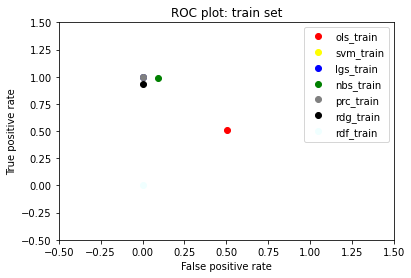

In [13]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

'''
for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([-0.5, 1.5, -0.5, 1.5])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()
'''

colors = ['red','yellow','blue','green','gray','black','azure']

for i in range(len(fits)):
    fit = fits[i]
    color = colors[i]
    label = fit.desc
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo',color=color, label=label)
    plt.legend(loc='upper right')
    #plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
    #         fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
    
#plt.plot(x, y, linewidth = '1', label = "test", color=' coral ', linestyle=':', marker='|')
plt.axis([-0.5, 1.5, -0.5, 1.5])
plt.title('ROC plot: train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [14]:
ols_predictions = ols.predict(X_train)

In [15]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
33
The cat is out of the bag. User ALR admitted his CONFLICT position, its on WIKI for all to see.
* * * * * * * * * 
230
"Welcome!

Hello, , and welcome to Wikipedia! Thank you for your contributions. I hope you like the place and decide to stay. Here are some pages that you might find helpful:
The five pillars of Wikipedia
Tutorial
How to edit a page
How to write a great article
Manual of Style
I hope you enjoy editing here and being a Wikipedian! Please sign your messages on discussion pages using four tildes (~~~~); this will automatically insert your username and the date. If you need help, check out Wikipedia:Questions, ask me on , or ask your question on this page and then place {{helpme}} before the question. Again, welcome!   ZX Wolfie "
* * * * * * * * * 
233
Yes, I know! I don't know why they still haven't created a new Gex version for the PLaystation 2.
* * * * * * * * * 
263
An imprssive enough feat for teenagers back in 1995-96... the making a

5431
March 2007 
 Please stop. If you continue to vandalise Wikipedia, as you did to Mesopotamia, you will be blocked from editing.   
If this is a shared IP address, and you didn't make any unconstructive edits, please ignore this warning
* * * * * * * * * 
5480
"

 Msa Garratts 

Hi,

The idea about an article is a good one, but unfortunately you've started out with an error. That is understandable as the subject is complex. 

The WAGR first imported the M class Garratts, in 1911. These are very important locos, because they are the third class of Garratt to be built, and the first ""main line"" Garratt, showing the potential as a heavy freight hauler. They were followed up in 1912 by the Ms class, only difference being the Ms class were superheated. So they were also the first class of Garratts to be the subject of a repeat order. Both classes were built by Beyer-Peacock.

The Msa class were constructed in 1930 by the WAGR in their own workshops. Apparently a copy of the Ms class, t

10213
"

 Oblivion(Novel) 

The last book reveals Jamie ended up in Saint Boltoph's Church in Boston, England. The other four Gatekeepers are scattered around the world, with Scarlett and Richard Cole ending up in Giza, Egypt. Matt and Lohan Shan-Tung end up in the Basilica de Nossa Senhore de Nazare in Belem, Brazil and Pedro and Scott ended up in the Abbey of San Galgano in Italy.
Ten years have passed since the destruction of Hong Kong, and the Old Ones have revealed themselves to the world, as the war is slowly destroying humanity, and, as predicted, humanity forms a resistance to them, the ""World Army."" Baker, President of the United States, is opposing this resistance, leading to all out warfare with rebels and government forces. Behind it all are the Old Ones, manipulating events from Antarctica, where they draw humanity with promise of easy victory when in reality Matt has a vision revealing the resistance's defeat. He tries to warn the resistance's leader.
Scott is converted

14895
"

Robeson
MLK's legacy section makes similar ""unsourced"" claims and so does Baker without any sources. (Baker's article also incorrectly she was the first AA to not play segregated houses when it was Robeson according to three historians)I have sources for each sentence I write, I'm simply making sure they are not reverted as the article is in flux. Also as Str1977 tagged the article and then vanished, how long does his tagging have to stand? Do we have to wait weeks for him to show up again? Thanks for your time.   9:39, 18 December 2010 (UTC)"
* * * * * * * * * 
14909
Unless, they are about Whatisjoppa.com
* * * * * * * * * 
14918
"

I'm trying to open a dialog here.  Listen to what I have to say and I'll listen to you.  Don't delete this.  While we are in talks I won't do vandalize.  -The Masked Flag of Freedom

Keep the flagship on there and I'll stop the jihad on you. Keep removing it and you are just asking for this situation to get 200 times worse. You lock out this pag

19686
I am reopening discussions
* * * * * * * * * 
19723
What is this? 

Hello,
After I finally though I knew was it was, you denyed me success!  )
Do you know what audio format it is?  I will make a link in the appropriate site.
* * * * * * * * * 
19784
You should tell us researcherers atlest where its located:(, that makes us feel very bad:(
* * * * * * * * * 
19916
"

 Low Weald 

Hi Peter, I see you have made various edits to the Weald, Holmesdale etc. As someone with a mainly geological interest I tend to look on the Weald rather loosely as ""the big hole in the chalk"". Would you count Holmesdale as part of the 'Low Weald', or should this be restricted to the rim of Weald Clay around the High Weald?   "
* * * * * * * * * 
19966
"

For anyone interested in accurate (not deliberately misleading) information about the ""ten-string guitar"" (i.e. not the garbage that will no doubt soon be presented here), see www.myspace.com/tenstringguitar []. (Tthough my temporary site has now bee

24697
Creation Science 

This article could use some more eyes.
* * * * * * * * * 
24732
"

 October 2010 

Hello, you were mentioned on WP:ANI . Regards  (TALK) "
* * * * * * * * * 
24733
"

Welcome

Hello, and welcome to Wikipedia! Thank you for your contributions. I hope you like the place and decide to stay. Here are some pages you might like to see:

 The five pillars of Wikipedia
 How to edit a page
 Help pages
 Tutorial
 How to write a great article
 Manual of Style

You are welcome to continue editing articles without logging in, but you may wish to [ create an account]. Doing so is free, requires no personal information, and provides several benefits. If you edit without a username, your IP address () is used to identify you instead.

In any case, I hope you enjoy editing here and being a Wikipedian! Please sign your comments on talk pages using four tildes (~~~~); this will automatically produce your IP address (or username if you're logged in) and the date. If you need help,

28854
­­ 
Yeah, revert my edit, you conformist.
* * * * * * * * * 
28863
"

 In fact 
Most of the already-existing text (e.g. terms such as ""reckless"" or ""egotistical"") would also qualify as non-neutral if subjected to a thorough scrutiny.   "
* * * * * * * * * 
28897
hi my name is matt and im a big fan of dolly parton. and i was wondering if dolly is here. dolly if your readig this letter im a hug fan. and also do u raise any horses. I have one of my own. we think she is pregnant and if so the foal is due in april or may of 2006. and I just turned 15 years old july 3.  thankx. 6 July 2005 03:30 (UTC)
* * * * * * * * * 
28982
What? What?
You sent a message to me for calling During a tyrant, why?  Its not that badd of a comment, its just an opinion, Loc.  I believe in the first ammendment.  Payne2thamaxx
* * * * * * * * * 
29140
A Link to the Past
Hi,
I never had any discussions with A Link to the Past, just reverted a blanking as I would delete any other form of vandalism I came ac

33864
How can I be trolling when it was Andy The Grump who started with the insults. Is he trolling as well? 64.38.197.224
* * * * * * * * * 
34063
"Ahhhh . . . . it always feels good to have the last word, to get in the last word. Although I don't sign my edits, you can see that from the SinBot that I am the person that started this Discussion of formatting the table (LOL). Yes, good to see that everybody has more or less agreed upon a non-descript colour format - fair enough (better than no colour formatting for headings). Jack Merridew - I see that you went and posted somewhere else that ""Miley Cyrus's fans can't have their own colour scheme"". Idiot, I had never even heard of this Miley Cyrus creature until I happened upon her page, and - to be quite frank - I don't think I would like her music if I were to hear it - I'm 55 years old. Nitwit. But you're a know-it-all, aren't you Jack? You know how I know that??? Because I went and looked at your edits, and you apparently spend hal

38079
Moved back from my page 

24 Hour Block

You have been blocked from editing for 24 hours for willful disruption and unrepentent personal attacks. You have long exhaunsted Letzter Kunstgriff as a form of rehtroical device, and its use is prohibited, as a non-negotiable policy on Wikipedia. Note that if personal attacks and incivilities ensue on your own talk page during the block period, the page will then be protected and the block period extended accordingly.  
 El C, I feel I should ask you to unblock  
We shall let other admins decide, this time. I warned him of this on multiple occasions before he has directed a single insult toward me, weeks ago. But the disruption & attacks have become unacceptable again. And Marsden would not have attacked me if it wasn't for me taking him to task for it, with multiple pleas preceding the warning of an impeding block, which he then took care to disregard.  
 I have raised this issue on Wikipedia:Administrators%27_noticeboard#El_C.27s_block

42384
"
 Please don't write silly things on my wall. Obviously, I didn't change my comment in any meaningful way; I only added to my original argument. You're allowed to edit your own comment; nothing was changed that affected the context in which someone replied. As you can see at WP:REDACT, it refers to editing your own comments to to correct false information or remove (or redact) personal attacks  and warns against the possibility that Removing or substantially altering a comment after someone else has replied may deprive the reply of its original context; I fail to see how this applies to these edits or could cause an issue regarding all two replies - yours claiming speedy doesn't apply and the other one that appears to support that this article needs to take a one-way trip to Delete Street.  YO 😜 "
* * * * * * * * * 
42400
Nevermind 

I'm happy with my new page and I dont think it should be changed.
* * * * * * * * * 
42488
I think Wintersdoor needs to examine this subpage of min

47040
If you want a good laugh take a look at the last few comments here .
* * * * * * * * * 
47105
Thanks for including in the disscusion. Neutral people can always help in this kind of disscusions.
* * * * * * * * * 
47141
Is it true... 

That umbrellas attract thunder? So if you're carrying one during a thunderstorm you risk a higher chance of being hit?
* * * * * * * * * 
47593
hey 

I noticed you undid my last edits? why was that? sure i may not have all the latest pogs, but i try my best? isn't this america after all? come on. i have all the pogs.
* * * * * * * * * 
47611
"

""Katara""
I've removed the section entirely. I don't care if you like to pretend that Katara and Zuko are meant for each other. It's still not case, and there has been no indication whatsoever. Thus, there's little point to actually have the section and exempt Toph and Sokka beyond the insane delusions of shippers.  "
* * * * * * * * * 
47691
April 2007 
 Please stop. If you continue to vandalize Wikipedia, 

51583
Trolling campaign.

Who has changed this from ragnarok to ragnarök??? Dude you probably don't know a much about this subject, so you will do best in just leave it. You can't relate everything to Snorre. Snorre's book is mostly a collection taken from different places. 
The guy who started this article was right and it's not second-guessing.  Comanche cph
* * * * * * * * * 
51584
"

 Milhist reviews March-May 2008 

   The Content Review Medal of Merit   In recognition of your contribution in improving Military history articles through A-Class and Peer Reviews, during the period March-May 2008, please accept this Content Review Medal of Merit,  talk "
* * * * * * * * * 
51630
to achieve a false consensus
* * * * * * * * * 
51752
"

Grizzlygus1 - I believe criticism sections are almost always going to be inappropriate in Wikipedia. Just about everyone has somebody who disagrees with them about something. Some, like outspoken atheists, will have more than many from conservative reli

56243
What are you doing on Wikipedia when you could be out giddily binning cats?  Nitpicking power freak.
* * * * * * * * * 
56290
leave da message for da klarky kat
* * * * * * * * * 
56310
"

 photo permission 

When the original uploader inquired me about this photo, I informed her that my files were all licensed under a creative commons sharealike license and were free to be used in any way before she uploaded it.

I also attached a creative commons licensing tag and a proper description template to the image, and have sent a photo permission email to the address requested. Hopefully this is enough to end the questionable status of the image. weev talk 2 me G N A A™ "
* * * * * * * * * 
56333
"

The ""Note For Admins"" doesn't mean bubkis, my poor porcine person.  Your use of that external link negates ANY validation that you may wish to portray while on Wikipedia; even several long-time admins on here have said that your site is ""questionable.""  For you to try to pass yourself 

60282
cited only to Eichenwald
* * * * * * * * * 
60301
Transnistria 

The recent addition to the Transnistria article was great, but I have three thoughts. 1. The added content is similar to content that I previously added in a preceding paragraph regarding Moldova's increased enforcement on restriction of Russian military use of airports controlled by Moldova.  Perhaps our content should be merged in one of the paragraphs?  2. Some of the new content seems very similar to that contained in the added reference.  3. The last line of content, while reflecting the reference, could be seen as non-NPOV without a reference that it is the Moldovan and western viewpoint.  Just some thoughts.
* * * * * * * * * 
60383
Nice research sherlock, a simple whois will tell you that the anony user who keeps reverting the templates will show you that that's not me.
* * * * * * * * * 
60390
Sorry, but I'm not an administrator and therefore don't have any ability to revert page moves.  You should report t

65061
"

You both have far-right agendas, and Manutglory is recruiting you because he is a member of Warren's church and therefore has a conflict of interest.  He's having trouble inserting bias into the article, so he needs your help.
The term for the two of you is ""cabal"", but such groups work best when they can skulk in the shadows.  I have a spotlight and I'm shining it right here.   "
* * * * * * * * * 
65068
"

Meetup in March
I see that you are listed as a participant in the WikiProject Melbourne. If you are a Melbourne resident I would appreciate your views on the suggested Meetup in March . Please give some indication of your interest, or otherwise, in the idea. Even a simple ""No thanks"" with your user name would be welcome and assist in assessing the level of support for a meetup. Thank you..  "
* * * * * * * * * 
65105
Why do you delete my comments? It's a good freaking idea, people like to see tits 131.151.66.248
* * * * * * * * * 
65174
Aha!  That's a different logical

And OH NO! Look who showed up. Is it the MILLIONS of other editors or hundreds of other admins for Wikipedia ready to discuss the atrocity occurring here? No. Just the usual suspects. Methinks they doth protest too much. Ohnoitsjamie says I was warned numerous times about personal attacks but the only ‘evidence’ he links has no warning by him for personal attacks. He says I attacked the person 'kind enough to mentor me' but his link shows no comment by me. He says that ‘If I didn't block you, someone else would have.’ Stand back everyone. The omniscient Ohnoitsjamie is going to predict the future actions of all other Admins. Case and point. Ohnoitsjamie is not interested in the appearance of an impartial decision. He would rather save us all the time that justice takes and act as accuser, jury, and executioner.
* * * * * * * * * 
70349
"
BTW, I think you don't actually expect me to respect a topic ban when an user ready to defend the characterisation of a Nazi invasion as a ""liberatio

74747
Question 

Could you tell me what articles you plan to edit once your block expires?  I'd like to see if you plan to edit anything other than this talk page.   (Elkspeak) 

Blocked
Your IP address  and, in fact, the entire range of IP addresses owned by Velocity Telephone, Inc.  has been blocked.  If I ask you a serious question relating to your future on Wikipedia and then you revert it telling me I'm trolling and that I should be blocked, then you don't deserve any sort of editing privileges whatsoever on Wikipedia.  This is an encyclopedia, not a soapbox.   (Elkspeak)
* * * * * * * * * 
74776
What is Zizang then? 

An anonymous contributor on ipaddress 81.229.147.109 changed a section the explanation of the railways name from:

 The line is named after its termini, Xizang being a phonetic transcription of the name for Tibet in Putonghua

to

 The line is named after its termini, Xizang, which is the name for Tibet in Putonghua.

The second is certainly wrong, as Zizang is a pi

* * * * * * * * * 
79331
"
 ""India's First Empire"" "
* * * * * * * * * 
79338
"
My colleague would like to know how to delete his accounts (those that are not blocked), and would like to know if it is possible to delete his talk pages because he wants to ""disappear from the Internet.""  "
* * * * * * * * * 
79426
Found the scientific name.  Ⓣ
* * * * * * * * * 
79449
"

 trekbbs 

Thank you for your opinions in the TrekBBS AFD.  I do not agree with the closing admin's decision and have listed this now under Deletion Review. As you had participated in the AFD, I wished to inform you this in case you wished to voice your opinion on this (view my history)/(How am I doing?) "
* * * * * * * * * 
79476
"* Thanks for contributing to Wikipedia.  Unfortunately, the commercial links/content you added  were inappropriate, as Wikipedia is an encyclopedia and should not be used for advertising or a collection of external links.  See the welcome page if you'd like to learn more about contributing

83533
Small TextInsert non-formatted text here[[Media:Media:Example.oggMedia:Example.ogg]]]111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111

88062
"::Great work. I may have some more pictures from Seville Municipal Archive. If I get a chance I will add these today. Someone with more time, may want to take care of expanding the Coria del Río stub too. talk 

"
* * * * * * * * * 
88102
Notes 
I´ve tried to add some of the fotnotes which the article is missing, but somebody has changed back to an earlier version without notes, where it is stated that the text lacks notes. Why do you change back?
* * * * * * * * * 
88111
Hmmm. I cannot find where I got the 30-day notion. Am I the only one who remembers that? It is unlikely me to mis-remember something like that. 

As for my rationale behind creating the Classic page and linking it to the Main Page....it was not because I am unhappy with the Main Page. It was because I thought it was a trial period. And I didn't want the other version to get out of date.  01:58, 26 Feb 2004 (UTC)
* * * * * * * * * 
88155
Oh the eighteenth century was the most glorious of all centuries for Britis

92416
Vulcan 

I'm sorry for my remark but this guy looks like a Vulcan. )
* * * * * * * * * 
92441
"

 Blocked for 24 Hours 

 (talk) "
* * * * * * * * * 
92447
"

Invitation

Please accept this invite to join the Red Sox WikiProject, a WikiProject dedicated to improving all articles associated with the Boston Red Sox. Simply click here to accept! "
* * * * * * * * * 
92546
It seems rather confusing and contradictory for me to read that Naseerudin Shah is a descendant of an Afghan warlord named Jan Fishan Khan and his surname is Shah which is indicative of his Syed descent i.e. Arab and from the Prophet's (PBUH). Khan is an indication of Pashtun or Mughal affiliation and I have read in many sources that Idries Shah claimed to be a descendant of Bukhari Syeds as did Syed Kamal Shah the late Pakistani film star. Please can someone shed light on this. Moarrikh
* * * * * * * * * 
92568
Your last few blocks accomplished that rather nicely, and that will continue to happen so long as you pe

96981
Support - There's no basis of being isolate language. Besides, there are some proofs that it's connected to Altaic langugages.
* * * * * * * * * 
97012
"
Support. Follow the usage of reliable sources. Also, the Trends and Insights data suggest that this authoritative usage has become the most common name, and is only becoming more so. I remember during the last RM, some user said that they would only reconsider their opposition to ""Myanmar"" if the government becomes a liberal democracy. (This political reasoning appears to lurk behind users' assertions against the evidence that ""Myanmar"" is the ""common name"".) However, the politicking about the name by Western governments is rapidly changing in response to the 2011–2012 Burmese political reforms (e.g., Australia).   "
* * * * * * * * * 
97030
I was also eyeing the “Jane link” as inappropriate clutter, especially given that the Burpee Museum has its own page. It might be appropriate under T-Rex or Theropods, but not here. Se

101524
No problem, I left it as a stub because I knew she was highly notable, but I wasn't familiar with the subject area. Thanks for the expansion!  account
* * * * * * * * * 
101534
"

 Please do not vandalize pages, as you did with this edit to Forest School Camps. If you continue to do so, you will be blocked from editing.    "
* * * * * * * * * 
101801
Blocked 
I have blocked this account, as an admitted sockpupptet of
* * * * * * * * * 
101855
"

 Please do not vandalize pages, as you did with this edit to Bathtub. If you continue to do so, you will be blocked from editing.  -PRIME "
* * * * * * * * * 
101921
through the use of different accounts and anonymous editing
* * * * * * * * * 
101924
REDIRECT Talk:James Hadley (American scholar)
* * * * * * * * * 
102014
"

 libtool 

Hi Hibou, if you're still here. Saw your remark on libtool, I believe you are right, it's a useless link. Maybe you could delete it ?

I'm not going to because every time I change anything on wikipedia som

106024
Yes I was referring to the faculty of science article. 

Thanks for responding so quickly.Welcome to Wikipedia and good luck with your article.
* * * * * * * * * 
106070
reolution 585p/720p
why is there no resolution in the infobox? is it because it is SD (585) like Halo 3 and Haze or some?
* * * * * * * * * 
106121
Hi Compman, thanks for contributing to wikipedia but I don't think we can accept materials copied directly from Canadian government webisites, so I'll have to tag some of your contributions as copyvio. Please let me know if I am wrong.
* * * * * * * * * 
106128
As it was your opinion.  You can take it anywhere you want.  You are still wrong and will be wrong afterward.
* * * * * * * * * 
106152
"

 ""Lame"" clarification 

Hi. You recently blocked . I guess it's irrelevant, but I was just curious. Maybe you meant that the whole thing was lame. Whatever. Best, crewer (yada, yada) "
* * * * * * * * * 
106195
"
Please reply. *weeps*  (Talk) "
* * * * * * * * * 
106196
"

110374
"
There's already Liturgical year, which discusses the Proper of the Season, although it can be a bit confusing since it discusses Catholic and Protestant uses, which aren't always the same. Any article would have to include both the pre- and post-Vatican II calendars, most notably Septuagesima and Passiontide as well as Ordinary Time vs. Time after Epiphany/Pentecost. The only change I see would be to create a specific ""Roman Catholic Liturgical Year"" article. As for the 1962 Calendar of the Saints, I created the older one mainly because I already had the pre-1955 calendar in electronic format, it's more consistent with past use since Trent, and it includes feasts that were later dropped. I think the same article can be used for both the 1955 and 1962 calendars, adding the rank of feasts (Double/III Class), and some sort of special formatting or asterisks for Feasts which are only on one or the other.  
Re-reading the first comment, I'm also starting to like the idea. We can 

114916
"Is this correct? 3 fT·Hz−½?  That reads as ""3 femto-tesla per (square root of hertz)"", which in turn expands to ""3 femto-tesla per (square root of (1/seconds))"".  Seems like a really odd unit to me.  "
* * * * * * * * * 
114935
Sourced stuff, there are other sources calling this an adventure film. By the way, Katniss goes to an exotic placer (a forest), something the characters of Inglourious Basterds don't do. I don't think this is action, as the lord of the rfilms have 45 minutes of action and are not considered action films for imdb, but they have 100000x more action than this film and leon the professional. By the way, Hunger Games has 1000000000x more adventure than inglourious basterds.
* * * * * * * * * 
114976
ok mister photographer, they are demolishing the electric furnace melt from both sides tomorrow, i'd go down to third street and take a stool so you can shoot over the fence unless you have wire clippers. a picture is worth a thousand words. your not going to 

119692
"

The potential for expansion does not justify keeping something that is so short and lacking in context. Donald has already identified two separate articles that contain a lot of information about the 2000 controversy, and United States presidential election, 1876 has a detailed analysis of the double returns from Florida, which covered everything that was in this article until a few moments ago.

If you sufficiently expand the article, I can support keeping it, but it's sad that only a prod got anybody's attention on this article, and it appeared that you had stopped after your burst of edits from Friday. '''''' (talk) "
* * * * * * * * * 
119714
No, you
Please quit vandalizing my talk page.  It's getting very annoying and giving other wiki users a false perception of me.  I will be forced to contact the admin if you continue your actions.
* * * * * * * * * 
119737
Link Nr. 6 does not work !!
* * * * * * * * * 
119744
"
I came up with the scrollbar idea (attack this →T §← guy

124203
"

I know W. Lloyd-Thomas and Clifford L.B. Hubbard did some of the older research on the corgi breeds (1930s).  W. Lloyd-Thomas mentioned the Teckel connection (he called it ""Tekal"") and dated the breed's orgin to around 1200 BC in papers he wrote (some of which I've read).  As is typical in writings of that era, his history is flowery and wordy and doesn't give specifics about the research.  He does say that mid-Cardiganshire is ""particularly wealthy in the remains of early Celtic fortifications (source: ""What the Modern Corgi Owes to its Cardigan Ancestors,"" AKC Gazette, October 1935),"" and I can only guess that it's from these remains that the corgi has been dated.  Incidently, it might be better to call the early corgi a ""livestock dog"" rather than a ""herding dog,"" as it was more of a guard...not unlike the Rottweiler.  I'm curious what the reason for the doubt is, though...does the corgi just seem recent?  I see no particular reason for skepticism...Celts have be

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [16]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3218, 'Neg': 28697, 'TP': 1633, 'TN': 14001, 'FP': 14696, 'FN': 1585, 'Accuracy': 0.4898637004543318, 'Precision': 0.10000612407373385, 'Recall': 0.5074580484773151, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [17]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3218, 'Neg': 28697, 'TP': 2058, 'TN': 27340, 'FP': 1357, 'FN': 1160, 'Accuracy': 0.9211342628857904, 'Precision': 0.6026354319180088, 'Recall': 0.6395276569297701, 'desc': 'svm_test'}


### MODEL: logistic regression

In [18]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3218, 'Neg': 28697, 'TP': 2035, 'TN': 27408, 'FP': 1289, 'FN': 1183, 'Accuracy': 0.9225442581858061, 'Precision': 0.6122141997593261, 'Recall': 0.632380360472343, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [19]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3218, 'Neg': 28697, 'TP': 2511, 'TN': 19247, 'FP': 9450, 'FN': 707, 'Accuracy': 0.6817483941720194, 'Precision': 0.20993227990970656, 'Recall': 0.7802983219390927, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [12]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3275, 'Neg': 28640, 'TP': 2119, 'TN': 27355, 'FP': 1285, 'FN': 1156, 'Accuracy': 0.9235155882813724, 'Precision': 0.622502937720329, 'Recall': 0.6470229007633588, 'desc': 'prc_test'}


In [13]:
nn_performance_test = BinaryClassificationPerformance(nn.predict(X_test), y_test, 'nn_test')
nn_performance_test.compute_measures()
print(nn_performance_test.performance_measures)

{'Pos': 3275, 'Neg': 28640, 'TP': 2240, 'TN': 27853, 'FP': 787, 'FN': 1035, 'Accuracy': 0.9429108569638102, 'Precision': 0.74000660720185, 'Recall': 0.683969465648855, 'desc': 'nn_test'}


In [14]:
nn2_performance_test = BinaryClassificationPerformance(nn2.predict(X_test), y_test, 'nn_test')
nn2_performance_test.compute_measures()
print(nn2_performance_test.performance_measures)

{'Pos': 3275, 'Neg': 28640, 'TP': 2164, 'TN': 28029, 'FP': 611, 'FN': 1111, 'Accuracy': 0.9460441798527338, 'Precision': 0.7798198198198198, 'Recall': 0.6607633587786259, 'desc': 'nn_test'}


### MODEL: Ridge Regression Classifier

In [21]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3218, 'Neg': 28697, 'TP': 1839, 'TN': 26805, 'FP': 1892, 'FN': 1379, 'Accuracy': 0.8975090083033057, 'Precision': 0.49289734655588313, 'Recall': 0.5714729645742698, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [22]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3218, 'Neg': 28697, 'TP': 0, 'TN': 28697, 'FP': 0, 'FN': 3218, 'Accuracy': 0.8991696694344352, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_test'}


/Users/xichen/Desktop/ml-master/final_assignment_1/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### ROC plot to compare performance of various models and fits

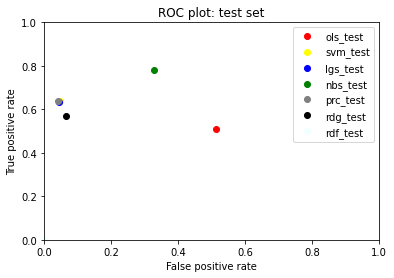

In [23]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]
colors = ['red','yellow','blue','green','gray','black','azure']

for i in range(len(fits)):
    fit = fits[i]
    color = colors[i]
    label = fit.desc
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo',color=color, label=label)
    plt.legend(loc='upper right')
    #plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
    #         fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
    
#plt.plot(x, y, linewidth = '1', label = "test", color=' coral ', linestyle=':', marker='|')
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [15]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='./toxiccomments_test.csv', my_random_seed=1, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of CountVectorizer X:
(153164, 189775)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0          72          10
1          13           1
2          16           0
3          38           3
4           7           1
5          16           2
6          31           4
7           6         

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [16]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = nn2.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.19505889112324046


In [17]:
raw_data.head()

,id,comment_text,word_count,punc_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1


In [18]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,False
2,00013b17ad220c46,False
3,00017563c3f7919a,False
4,00017695ad8997eb,False


In [19]:
my_submission.shape

(153164, 2)

In [20]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('./toxiccomments_submission_iter3.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation